In [7]:
import xarray as xr
import pandas as pd
import numpy as np
import meitner
import warnings

import matplotlib.pyplot as plt

from vamas import Vamas

In [8]:
def check_vamas_input(path=None, vms=False):
    '''
    Check whether a path to VAMAS data is specified, a VAMAS object is passed, or an invalid input is given.
    
    Args:
        path: Path to VAMAS data, including extension.
        vms: Vamas object.
        
    Returns:
        Vamas object.
    '''
    if isinstance(path,str) and (path[-4:] == ".vms"):
        vms = Vamas(path)
    elif vms:
        pass
    else:
        warnings.warn(
            'Data format is not VAMAS.'
        )
        return
    return vms


def read_vamas_blocks(path=None, vms=False):
    '''
    Wrapper for Vamas() to read VAMAS block IDs.
    If path is specified, VAMAS data are loaded.
    Alternatively, a Vamas object (vms) can be passed directly.
    
    Args:
        path: Path to VAMAS data, including extension.
        vms: Vamas object.
        
    Returns:
        List of VAMAS block IDs.
    '''
    vms = check_vamas_input(path=path, vms=vms)
    return [vms.blocks[k].block_identifier for k in range(len(vms.blocks))]


def import_single_vamas(path=None,
                        vms=False,
                        region_id=None,
                        read_phi=False):
        '''
        Wrapper for Vamas() to import XPS data into an Xarray Dataset.
        If path is specified, VAMAS data are loaded.
        Alternatively, a Vamas object (vms) can be passed directly.
        
        Args:
            path: Path to VAMAS data, including extension.
            region_id: Identifier for VAMAS block. Can be string (e.g., 'Au 4f 690') or integer index of block (more robust).
                # TODO Identify when multiple VAMAS blocks share the same name and prompt user to select.
            read_phi: If True, reads the analyzer work function from VAMAS data and factors it into the binding energy calculation.
            
        Returns:
            Xarray dataset with variables ke (kinetic energy) and cps (raw counts) and coordinate be (binding energy).
        
        # ! Data processing options (normalize, shift) have been moved downstream.
        '''

        vms = check_vamas_input(path=path, vms=vms)

        # check spectra contained in VAMAS by pulling block_identifier for each block
        ids = read_vamas_blocks(vms=vms)
        n = len(ids)
        
        print('Found ' + str(len(ids)) + ' blocks.')
        print()
        
        # check for and log duplicate block IDs
        duplicate_flag = n != len(set(ids))
        if duplicate_flag:
            print('Detected multiple VAMAS blocks with the same name.')
            print()
            duplicate_ids = [id for id in ids if ids.count(id) > 1]
        
        # if region_id not specified, get user input
        if (region_id == None) or (not region_id):
            print(pd.DataFrame(ids, columns=['id']))
            region_id = input('Specify block ID or index to access...')
            try:
                region_id = int(region_id)
            except ValueError:
                pass
        
        # block index specified directly
        if isinstance(region_id, int):
            idx = region_id
        # get block index from block ID
        elif isinstance(region_id, str):
            if region_id in duplicate_ids:
                print('String specification is ambiguous.')
                print('Defaulting to first instance.')
            idx = ids.index(region_id)
            
        # access spectrum, pull counts (c), generate KE range, and calculate BE from KE
        dataBlock = vms.blocks[idx]
        cps = dataBlock.corresponding_variables[0].y_values # ! assumes counts are always the first corresponding variable...
        n = len(cps)
        ke = np.linspace(dataBlock.x_start, dataBlock.x_start + dataBlock.x_step*(n-1), n)
        
        # analyzer work function
        if read_phi:
            phi = dataBlock.analyzer_work_function_or_acceptance_energy
        else:
            phi = 0
        # excitation energy
        hv = dataBlock.analysis_source_characteristic_energy
        print("Excitation energy:")
        print(str(hv) + " eV")

        
        # compute binding energy
        be = hv - ke - phi
        
        return xr.Dataset(
            data_vars=dict(
                cps=('be', cps),
                ke=('be', ke)
            ),
            coords=dict(
                be=('be', be)
            )
        )

In [9]:
file = 'sh_all.vms'

In [10]:
ids = read_vamas_blocks(path=file)

In [11]:
ds = import_single_vamas(file, region_id=6)

Found 43 blocks.

Detected multiple VAMAS blocks with the same name.

Excitation energy:
1486.69 eV


In [12]:
data = meitner.Xps.from_vamas(path=file, region_id=6)

Found 43 blocks.

Detected multiple VAMAS blocks with the same name.

Excitation energy:
1486.69 eV


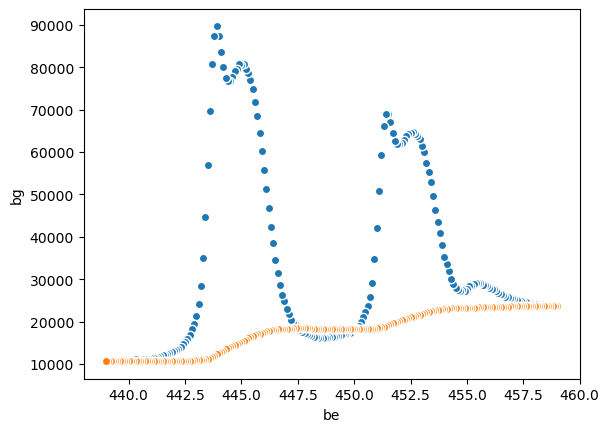

In [13]:
fig, ax = plt.subplots()
data.ds.plot.scatter(x='be',y='cps',ax=ax)
data.ds.plot.scatter(x='be',y='bg',ax=ax)

In [14]:
ds = data.ds

In [20]:
ds.max(dim='be')

<xarray.Dataset>
Dimensions:    ()
Data variables:
    cps        float64 8.979e+04
    ke         float64 1.048e+03
    bg         float64 2.361e+04
    cps_no_bg  float64 7.755e+04